In [3]:
!pip install ott-jax
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 19.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 36.5 MB/s eta 0:00:00


In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pylab as plt
from ott.geometry import pointcloud,costs
from ott.solvers.linear import sinkhorn
import ot.plot

In [5]:
rng = jax.random.PRNGKey(0)
rng, rngs = jax.random.split(rng, 3)
d, n_x, n_y = 2, 7, 11
x = jax.random.normal(rngs[0], (n_x, d))
y = jax.random.normal(rngs[1], (n_y, d)) + 0.5
x_old = x

In [27]:
def classification_otda_data_maker(n_s,n_t,noise,n_s_out,n_t_out,power_out, n_label = 3, rng_key = jax.random.PRNGKey(0)) :
    """
    This function will create a simply dataset with a source sample and a target sample with features and labels
    
    Theses arguments is the degree of complexity of the domain drift and the number of outliers respectly
    
    Args : 
        n
        noise 
        
    return x_s,y_s,x_t,y_t
    
    """

    keys = jax.random.split(rng_key, 5)

    # Source sample
    y_s = np.floor((np.arange(n_s)/ n_s * n_label)) + 1
    x_s = np.zeros((n_s, 2))
    y_s[y_s == 4] = 3

    x_s[y_s == 1, 0] = -2.
    x_s[y_s == 1, 1] = -2.
    x_s[y_s == 2, 0] = -2.
    x_s[y_s == 2, 1] = 2.
    x_s[y_s == 3, 0] = 2.
    x_s[y_s == 3, 1] = 0
    x_s[y_s != 3, :] += noise * jax.random.normal(keys[0], (sum(y_s != 3), 2))
    x_s[y_s == 3, :] += 2 * noise * jax.random.normal(keys[1], (sum(y_s == 3), 2))
    
    for out in range(n_s_out): 
        row_sampled = jax.random.choice(keys[2], x_s.shape[0])
        x_s[row_sampled] = jnp.multiply(x_s[row_sampled], power_out) 


    #Target Sample
    y_t = np.floor((np.arange(n_t) * 1.0 / n_t * 3)) + 1
    x_t = np.zeros((n_t, 2))

    x_t[y_t == 1, 0] = -1.
    x_t[y_t == 1, 1] = -1.
    x_t[y_t == 2, 0] = -1.
    x_t[y_t == 2, 1] = 1.
    x_t[y_t == 3, 0] = 1.
    x_t[y_t == 3, 1] = 0
    x_t[y_t != 3, :] += 5 * noise * jax.random.normal(keys[3], (sum(y_t != 3), 2))
    x_t[y_t == 3, :] += 2 * noise * jax.random.normal(keys[4], (sum(y_t == 3), 2))
    
    for out in range(n_t_out): 
        row_sampled = jax.random.choice(keys[5], x_t.shape[0])
        x_t[row_sampled] = np.multiply(x_t[row_sampled], power_out) 
    
    return x_s,y_s,x_t,y_t



x_s,y_s,x_t,y_t = classification_otda_data_maker(100,100,0.5,1,1,5, rng_key=rng)

Text(0.5, 1.0, 'Target samples')

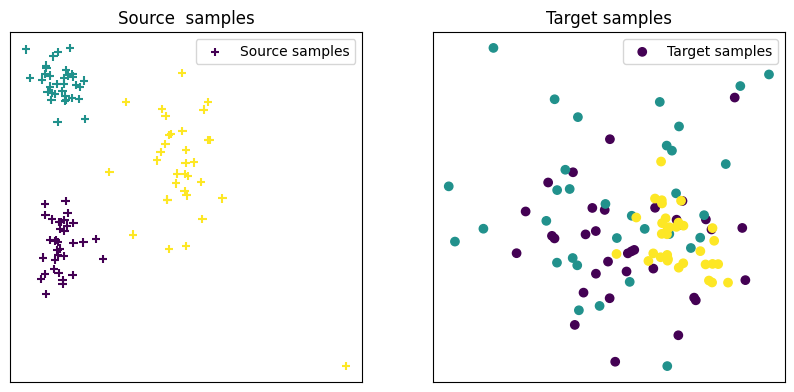

In [28]:
plt.figure(1, figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)
plt.title('Source  samples')

plt.subplot(2, 2, 2)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='Target samples')
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)
plt.title('Target samples')

In [ ]:
import ot
# Cost matrix
M = ot.dist(x_s, x_t, metric='sqeuclidean')
M

array([[17.1282738 , 20.25953511,  4.43046709, ..., 12.53436149,
        24.88609914, 10.9900244 ],
       [19.94974689, 12.99399248,  3.11545952, ..., 10.2018605 ,
        19.77422454,  6.72067954],
       [17.46461534,  9.36011174,  5.16477954, ...,  7.03459992,
        14.87199808,  3.98863779],
       ...,
       [18.92900854,  0.75231057, 20.52872846, ...,  3.00977416,
         2.96265148,  0.39199002],
       [ 0.89429037, 20.33005021, 38.12553611, ...,  3.80897159,
         8.39930735, 11.06074338],
       [ 8.69745232,  7.44267722, 34.8652125 , ...,  1.08930843,
         0.70932237,  4.03036895]])

In [43]:
# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=x_s, Xt=x_t)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=x_s, Xt=x_t)

# Sinkhorn Transport with Group lasso regularization
ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
ot_lpl1.fit(Xs=x_s, ys=y_s, Xt=x_t)

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=x_s)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=x_s)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=x_s)

/usr/local/lib/python3.10/dist-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [32]:
from ott.problems.linear import linear_problem

In [33]:
geom = pointcloud.PointCloud(x_s, x_t)  
problem = linear_problem.LinearProblem(geom)
solver = sinkhorn.Sinkhorn()

out = solver(problem)       

In [50]:
entropic_map = out.to_dual_potentials()
transported_samples = entropic_map.transport(x_s)


([], [])

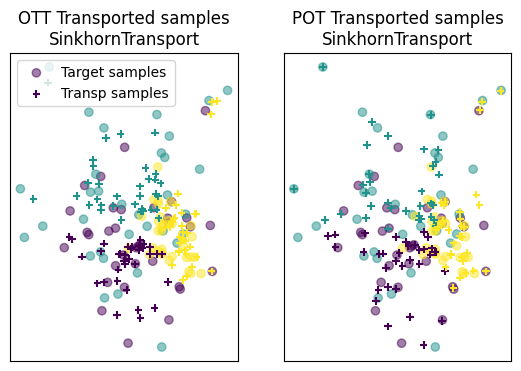

In [51]:
plt.figure(4, figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(transported_samples[:, 0], transported_samples[:, 1], c=y_s,
           marker='+', label='Transp samples', s=30)
plt.title('OTT Transported samples\nSinkhornTransport')
plt.legend(loc=0)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=y_s,
           marker='+', label='Transp samples', s=30)
plt.title('POT Transported samples\nSinkhornTransport')
plt.xticks([])
plt.yticks([])

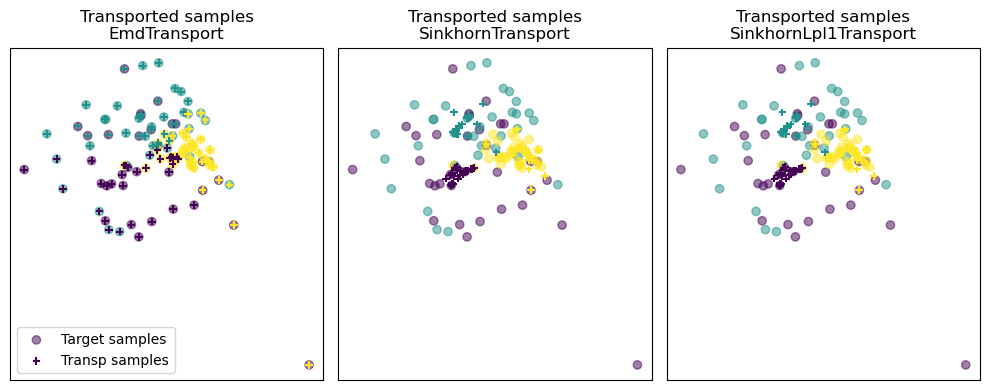

In [ ]:
# display transported samples
plt.figure(4, figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=y_s,
           marker='+', label='Transp samples', s=30)
plt.title('Transported samples\nEmdTransport')
plt.legend(loc=0)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=y_s,
           marker='+', label='Transp samples', s=30)
plt.title('Transported samples\nSinkhornTransport')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=y_s,
           marker='+', label='Transp samples', s=30)
plt.title('Transported samples\nSinkhornLpl1Transport')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

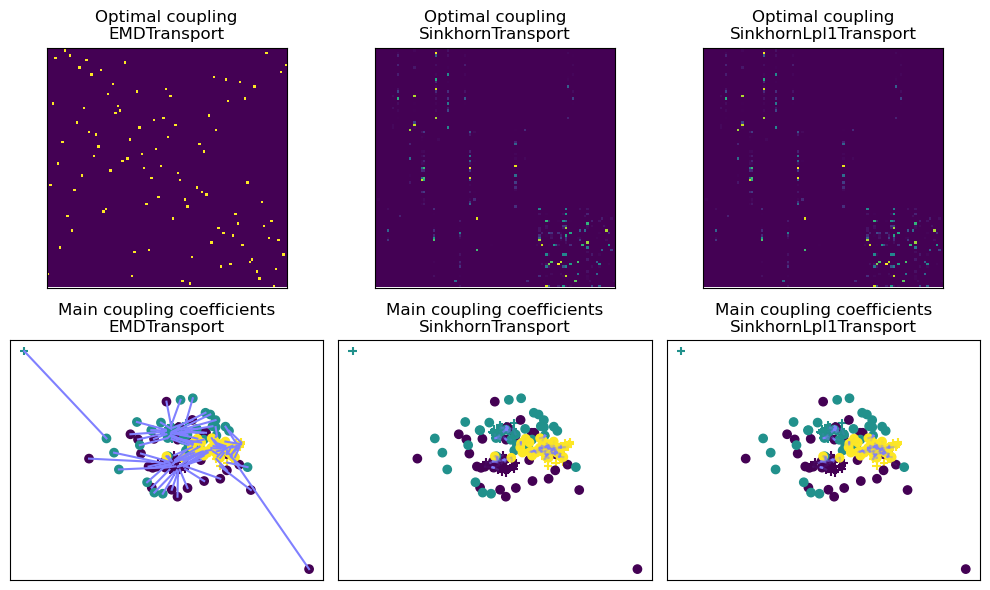

In [ ]:
plt.figure(2, figsize=(10, 6))

plt.subplot(2, 3, 1)
plt.imshow(ot_emd.coupling_, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Optimal coupling\nEMDTransport')

plt.subplot(2, 3, 2)
plt.imshow(ot_sinkhorn.coupling_, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Optimal coupling\nSinkhornTransport')

plt.subplot(2, 3, 3)
plt.imshow(ot_lpl1.coupling_, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Optimal coupling\nSinkhornLpl1Transport')

plt.subplot(2, 3, 4)
ot.plot.plot2D_samples_mat(x_s, x_t, ot_emd.coupling_, c=[.5, .5, 1])
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='Target samples')
plt.xticks([])
plt.yticks([])
plt.title('Main coupling coefficients\nEMDTransport')

plt.subplot(2, 3, 5)
ot.plot.plot2D_samples_mat(x_s, x_t, ot_sinkhorn.coupling_, c=[.5, .5, 1])
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='Target samples')
plt.xticks([])
plt.yticks([])
plt.title('Main coupling coefficients\nSinkhornTransport')

plt.subplot(2, 3, 6)
ot.plot.plot2D_samples_mat(x_s, x_t, ot_lpl1.coupling_, c=[.5, .5, 1])
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='Target samples')
plt.xticks([])
plt.yticks([])
plt.title('Main coupling coefficients\nSinkhornLpl1Transport')
plt.tight_layout()

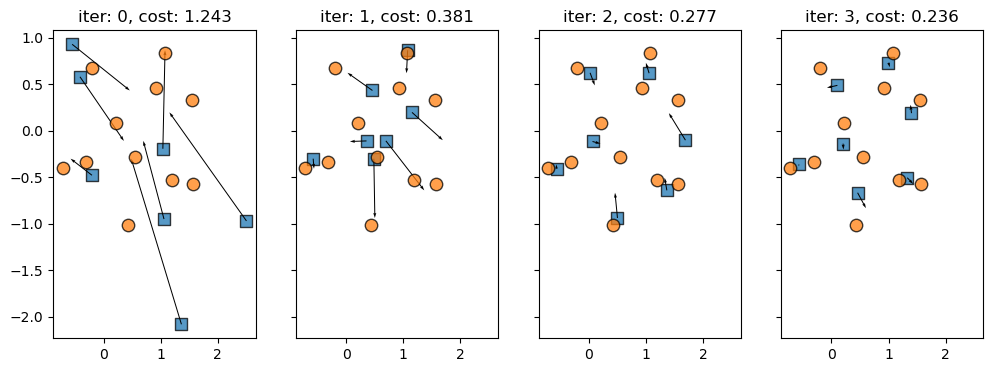

In [ ]:
step = 5.0
x = x_old
quiv_args = {"scale": 1, "angles": "xy", "scale_units": "xy", "width": 0.005}
f, axes = plt.subplots(1, int(step-1), sharey=True, sharex=True, figsize=(12, 4))

for iteration, ax in enumerate(axes):
    cost, grad_x = r_ot(x, y)
    ax.scatter(x[:, 0], x[:, 1], **x_args)
    ax.quiver(
        x[:, 0],
        x[:, 1],
        -step * grad_x[:, 0],
        -step * grad_x[:, 1],
        **quiv_args,
    )
    ax.scatter(y[:, 0], y[:, 1], **y_args)
    ax.set_title(f"iter: {iteration}, cost: {cost:.3f}")
    x -= step * grad_x

In [ ]:
cost

DeviceArray(0.23560537, dtype=float32)